In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

# We also need PrettyTensor.
import prettytensor as pt

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

data.test.cls = np.argmax(data.test.labels, axis=1)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [9]:
def plot_images(images, cls_true, cls_pred=None, noise=0.0):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Get the i'th image and reshape the array.
        image = images[i].reshape(img_shape)
        
        # Add the adversarial noise to the image.
        image += noise
        
        # Ensure the noisy pixel-values are between 0 and 1.
        image = np.clip(image, 0.0, 1.0)

        # Plot image.
        ax.imshow(image,
                  cmap='binary', interpolation='nearest')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

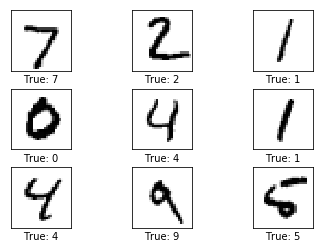

In [10]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [12]:
noise_limit = 0.35
noise_l2_weight = 0.02
ADVERSARY_VARIABLES = 'adversary_variables'
collections = [tf.GraphKeys.VARIABLES, ADVERSARY_VARIABLES]
x_noise = tf.Variable(tf.zeros([img_size, img_size, num_channels]),
                      name='x_noise', trainable=False,
                      collections=collections)
x_noise_clip = tf.assign(x_noise, tf.clip_by_value(x_noise,
                                                   -noise_limit,
                                                   noise_limit))
x_noisy_image = x_image + x_noise
x_noisy_image = tf.clip_by_value(x_noisy_image, 0.0, 1.0)

In [13]:
x_pretty = pt.wrap(x_noisy_image)
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [14]:
adversary_variables = tf.get_collection(ADVERSARY_VARIABLES)
l2_loss_noise = noise_l2_weight * tf.nn.l2_loss(x_noise)
loss_adversary = loss + l2_loss_noise
optimizer_adversary = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary, var_list=adversary_variables)

In [15]:
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [16]:
train_batch_size = 64
def optimize(num_iterations, adversary_target_cls=None):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # If we are searching for the adversarial noise, then
        # use the adversarial target-class instead.
        if adversary_target_cls is not None:
            # The class-labels are One-Hot encoded.
            
            # Set all the class-labels to zero.
            y_true_batch = np.zeros_like(y_true_batch)

            # Set the element for the adversarial target-class to 1.
            y_true_batch[:, adversary_target_cls] = 1.0
            
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # If doing normal optimization of the neural network.
        if adversary_target_cls is None:
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
        else:
            # Run the adversarial optimizer instead.
            # Note that we have 'faked' the class above to be
            # the adversarial target-class instead of the true class.
            session.run(optimizer_adversary, feed_dict=feed_dict_train)
            
            # Clip / limit the adversarial noise. This executes
            # another TensorFlow operation. It cannot be executed
            # in the same session.run() as the optimizer, because
            # it may run in parallel so the execution order is not
            # guaranteed. We need the clip to run after the optimizer.
            session.run(x_noise_clip)

        # Print status every 100 iterations.
        if (i % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [17]:
def get_noise():
    # Run the TensorFlow session to retrieve the contents of
    # the x_noise variable inside the graph.
    noise = session.run(x_noise)

    return np.squeeze(noise)

def plot_noise():
    # Get the adversarial noise from inside the TensorFlow graph.
    noise = get_noise()

    # Print statistics.
    print("Noise:")
    print("- Min:", noise.min())
    print("- Max:", noise.max())
    print("- Std:", noise.std())

    # Plot the noise.
    plt.imshow(noise, interpolation='nearest', cmap='seismic',
               vmin=-1.0, vmax=1.0)

def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]

    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]

    # Get the adversarial noise from inside the TensorFlow graph.
    noise = get_noise()

    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                noise=noise)

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [18]:
def make_immune(target_cls, num_iterations_adversary=500,
                num_iterations_immune=200):

    print("Target-class:", target_cls)
    print("Finding adversarial noise ...")

    # Find the adversarial noise.
    optimize(num_iterations=num_iterations_adversary,
             adversary_target_cls=target_cls)

    # Newline.
    print()

    # Print classification accuracy.
    print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False)

    # Newline.
    print()

    print("Making the neural network immune to the noise ...")

    # Try and make the neural network immune to this noise.
    # Note that the adversarial noise has not been reset to zero
    # so the x_noise variable still holds the noise.
    # So we are training the neural network to ignore the noise.
    optimize(num_iterations=num_iterations_immune)

    # Newline.
    print()

    # Print classification accuracy.
    print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False)

Optimization Iteration:      0, Training Accuracy:  17.2%


Optimization Iteration:    100, Training Accuracy:  90.6%


Optimization Iteration:    200, Training Accuracy:  85.9%


Optimization Iteration:    300, Training Accuracy:  89.1%


Optimization Iteration:    400, Training Accuracy:  92.2%


Optimization Iteration:    500, Training Accuracy:  92.2%


Optimization Iteration:    600, Training Accuracy:  96.9%


Optimization Iteration:    700, Training Accuracy:  95.3%


Optimization Iteration:    800, Training Accuracy:  93.8%


Optimization Iteration:    900, Training Accuracy: 100.0%


Optimization Iteration:    999, Training Accuracy:  96.9%
Time usage: 0:01:48


Accuracy on Test-Set: 96.6% (9664 / 10000)
Example errors:


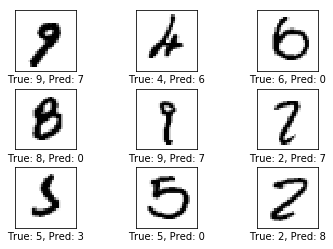

Optimization Iteration:      0, Training Accuracy:  17.2%


Optimization Iteration:    100, Training Accuracy:  96.9%


Optimization Iteration:    200, Training Accuracy:  95.3%


Optimization Iteration:    300, Training Accuracy:  95.3%


Optimization Iteration:    400, Training Accuracy:  98.4%


Optimization Iteration:    500, Training Accuracy:  95.3%


Optimization Iteration:    600, Training Accuracy:  96.9%


Optimization Iteration:    700, Training Accuracy:  96.9%


Optimization Iteration:    800, Training Accuracy:  90.6%


Optimization Iteration:    900, Training Accuracy:  96.9%


Optimization Iteration:    999, Training Accuracy:  93.8%
Time usage: 0:01:50
Noise:
- Min: -0.35
- Max: 0.35
- Std: 0.196507


Accuracy on Test-Set: 12.7% (1269 / 10000)
Example errors:


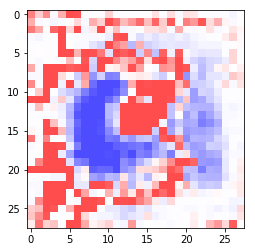

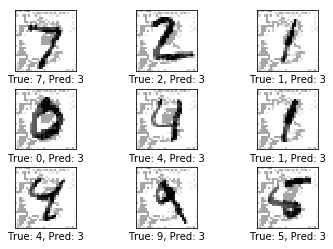

Confusion Matrix:
[[  58    0    0  921    0    0    0    1    0    0]
 [   0    0    0 1135    0    0    0    0    0    0]
 [   0    0   67  965    0    0    0    0    0    0]
 [   0    0    0 1010    0    0    0    0    0    0]
 [   0    0    0  982    0    0    0    0    0    0]
 [   0    0    0  868    0   24    0    0    0    0]
 [   0    0    1  893    0    1   63    0    0    0]
 [   0    0    0  994    0    0    0   34    0    0]
 [   0    0    0  961    0    0    0    0   13    0]
 [   0    0    1 1008    0    0    0    0    0    0]]
Target-class: 3
Finding adversarial noise ...


Optimization Iteration:      0, Training Accuracy:  96.9%


Optimization Iteration:    100, Training Accuracy:  98.4%


Optimization Iteration:    200, Training Accuracy:  98.4%


Optimization Iteration:    300, Training Accuracy: 100.0%


Optimization Iteration:    400, Training Accuracy:  95.3%


Optimization Iteration:    499, Training Accuracy:  98.4%
Time usage: 0:00:55



Accuracy on Test-Set: 12.3% (1228 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  31.2%


Optimization Iteration:    100, Training Accuracy:  98.4%


Optimization Iteration:    199, Training Accuracy:  93.8%
Time usage: 0:00:22



Accuracy on Test-Set: 95.9% (9587 / 10000)


In [19]:
def init_noise():
    session.run(tf.variables_initializer([x_noise]))

with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    optimize(num_iterations=1000)
    print_test_accuracy(show_example_errors=True)

    init_noise()
    optimize(num_iterations=1000, adversary_target_cls=3)
    plot_noise()
    print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

    make_immune(target_cls=3)